In [1]:
from pathlib import Path
from IPython.display import HTML, display
css = Path("../../../css/rtl.css").read_text(encoding="utf-8")
display(HTML(f"<style>{css}</style>"))

# فصل ۵ — درخت‌های تصمیم و گونه‌ها
## درس ۳: هرس‌کردن و بیش‌برازش در درخت‌ها

در این درس یاد می‌گیرید **چرا درخت‌های تصمیم بیش‌برازش می‌کنند**، چگونه **پیچیدگی درخت** را کنترل کنید، و چگونه از **هرسِ پیشین (Pre-pruning)** و **هرسِ پسین (Post-pruning / Cost-Complexity Pruning)** در عمل استفاده کنید. همچنین روش‌های تشخیص بیش‌برازش با **منحنی‌های یادگیری**، **منحنی‌های اعتبارسنجی** و **اعتبارسنجی متقاطع** را تمرین می‌کنید.

**داده‌های استفاده‌شده در این نوت‌بوک (به‌صورت تصادفی از مخزن شما انتخاب شده‌اند):**
- طبقه‌بندی چندکلاسه: `../../../Datasets/Classification/glass.csv`
- طبقه‌بندی دودویی: `../../../Datasets/Classification/diabetes.csv`
- رگرسیون: `../../../Datasets/Regression/house-prices.csv`

> نکته: همهٔ متن‌های نمودارها (عنوان، برچسب محور‌ها، راهنما/legend) عمداً در کد انگلیسی نگه داشته شده‌اند تا همین کد دقیقاً در نسخهٔ فارسی نیز بدون ترجمهٔ نمودارها استفاده شود.


### اهداف یادگیری

در پایان این درس باید بتوانید:

1. **بیش‌برازش در درخت‌ها** را از دید ظرفیت مدل، واریانس، و خرد شدن داده‌ها توضیح دهید.
2. تفاوت **هرسِ پیشین** و **هرسِ پسین** را بدانید و موقعیت مناسب هر کدام را تشخیص دهید.
3. مسیر **هرسِ کمینه‌سازی پیچیدگی-هزینه** (`ccp_alpha`) را در scikit-learn بسازید و $\alpha$ را با اعتبارسنجی انتخاب کنید.
4. هایپرپارامترهای درخت را به‌صورت امن با **اعتبارسنجی متقاطع** تنظیم کنید و از نشت داده جلوگیری کنید.
5. مدل‌های هرس‌شده و هرس‌نشده را با معیارها، اندازهٔ درخت و نمودارهای خطا مقایسه کنید.
6. هرس را هم برای **درخت‌های طبقه‌بندی** و هم **درخت‌های رگرسیون** به‌کار ببرید.

### ایدهٔ کلیدی (ظرفیت در برابر تعمیم)

یک درخت تصمیم می‌تواند آن‌قدر تقسیم کند تا هر برگ تقریباً خالص شود. این کار معمولاً خطای آموزش را نزدیک صفر می‌کند، اما اغلب خطای آزمون را افزایش می‌دهد.

این وضعیت را می‌توان با **شکاف تعمیم** توصیف کرد:
$$
\text{Gap} = \mathcal{L}_{\text{test}} - \mathcal{L}_{\text{train}}
$$

در بسیاری از درخت‌ها با افزایش عمق، $\mathcal{L}_{\text{train}}$ به‌طور یکنواخت کاهش می‌یابد، اما $\mathcal{L}_{\text{test}}$ ابتدا کاهش و سپس افزایش پیدا می‌کند (شکل U کلاسیک).


## ۱) چرا درخت‌های تصمیم بیش‌برازش می‌کنند؟

درخت‌های تصمیم یادگیرنده‌های **پُرواریانس** هستند:

- **تصمیم‌های محلی**: هر تقسیم به‌صورت حریصانه انجام می‌شود و تقسیم‌های اولیه مسیر بقیهٔ درخت را تعیین می‌کنند.
- **خردشدن داده‌ها**: با افزایش عمق، نمونه‌های هر برگ کمتر می‌شود و نویز بیشتر اثر می‌گذارد.
- **مرزبندی‌های محور-هم‌راستا**: با تعداد زیادی تقسیم می‌توان مرزهای بسیار پیچیده ساخت.
- **نبود هموارسازی ذاتی**: برخلاف مدل‌های خطی، خروجی درخت می‌تواند با یک تقسیم ناگهان تغییر کند.

### ۱.۱ شهودِ خردشدن داده‌ها

فرض کنید یک گره $n$ نمونه دارد. اگر تقریباً دو شاخه‌سازی متوازن داشته باشیم، بعد از $d$ سطح متوازن حدوداً داریم:
$$
\text{samples per leaf} \approx \frac{n}{2^d}
$$

وقتی این مقدار کوچک شود، بسیاری از برگ‌ها عملاً روی نویز فیت می‌شوند.

### ۱.۲ شهودِ سوگیری-واریانس (پیچیدگی درخت)

به‌صورت شهودی:

- درخت کم‌عمق → سوگیری بیشتر، واریانس کمتر
- درخت پُرعمق → سوگیری کمتر، واریانس بیشتر

هرس یعنی پیدا کردن **تعادل مناسب سوگیری-واریانس** برای مسئله و داده.


In [2]:
# Setup: imports, reproducibility, helper utilities
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.datasets import make_classification, make_regression

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def show_confusion(cm, class_names=None, title="Confusion matrix"):
    plt.figure()
    plt.imshow(cm, interpolation="nearest")
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(cm.shape[0])
    if class_names is None:
        class_names = [str(i) for i in range(cm.shape[0])]
    plt.xticks(tick_marks, class_names, rotation=45, ha="right")
    plt.yticks(tick_marks, class_names)
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], "d"),
                     ha="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()
    plt.show()


## ۲) یک نمایش سریع مصنوعی: عمق در برابر بیش‌برازش

قبل از رفتن سراغ داده‌های واقعی، با دادهٔ مصنوعی شهود می‌سازیم.

کارهایی که انجام می‌دهیم:
1. ساخت یک دادهٔ طبقه‌بندی نویزی.
2. آموزش درخت با `max_depth`های مختلف.
3. رسم دقت آموزش و آزمون.
4. مشاهدهٔ اینکه با بزرگ شدن درخت، بیش‌برازش چگونه ظاهر می‌شود.

### هنگام مشاهده به چه چیز دقت کنیم؟

- دقت آموزش افزایش می‌یابد (گاهی تا ۱.۰).
- دقت آزمون ابتدا بهتر می‌شود، سپس ثابت یا بدتر می‌شود.
- «بهترین عمق» معمولاً متوسط است، نه بیشینه.


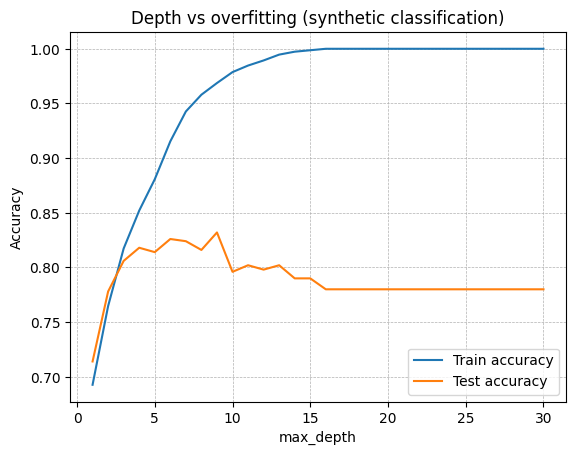

(9, 0.832)

In [3]:
# Synthetic classification: depth vs generalization
X, y = make_classification(
    n_samples=2000,
    n_features=20,
    n_informative=5,
    n_redundant=2,
    n_classes=2,
    flip_y=0.08,         # label noise
    class_sep=1.0,
    random_state=RANDOM_STATE
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y
)

depths = list(range(1, 31))
train_acc = []
test_acc = []

for d in depths:
    clf = DecisionTreeClassifier(max_depth=d, random_state=RANDOM_STATE)
    clf.fit(X_train, y_train)
    train_acc.append(clf.score(X_train, y_train))
    test_acc.append(clf.score(X_test, y_test))

plt.figure()
plt.plot(depths, train_acc, label="Train accuracy")
plt.plot(depths, test_acc, label="Test accuracy")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.title("Depth vs overfitting (synthetic classification)")
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.5)
plt.show()

best_depth = depths[int(np.argmax(test_acc))]
best_depth, max(test_acc)


## ۳) دو خانوادهٔ روش‌ها: هرسِ پیشین در برابر هرسِ پسین

### ۳.۱ هرسِ پیشین (توقف زودهنگام هنگام رشد)

با گذاشتن محدودیت‌ها، اجازه نمی‌دهید درخت خیلی بزرگ شود، مثل:

- `max_depth`: حداکثر عمق درخت.
- `min_samples_split`: حداقل تعداد نمونه برای تقسیم یک گره.
- `min_samples_leaf`: حداقل نمونه لازم برای یک برگ.
- `max_leaf_nodes`: حداکثر تعداد برگ‌ها.
- `min_impurity_decrease`: حداقل کاهش ناخالصی برای انجام تقسیم.
- `max_features`: محدود کردن تعداد ویژگی‌های قابل بررسی در هر تقسیم.

**مزایا**
- ساده، سریع، و مناسب برای grid search.
- کاهش زمان و حافظه روی داده‌های بزرگ.

**محدودیت‌ها**
- حساسیت به انتخاب: اگر خیلی زود متوقف شوید، سوگیری زیاد می‌شود.
- نیاز به جست‌وجوی دقیق هایپرپارامترها دارد.

### ۳.۲ هرسِ پسین (اول بزرگ کن، بعد کوتاه کن)

ابتدا یک درخت بزرگ می‌سازید و سپس آن را برای بهبود تعمیم هرس می‌کنید.

یکی از روش‌های رایج، **هرسِ کمینه‌سازی پیچیدگی-هزینه** است که زیر‌درخت $T$ را با کمینه کردن عبارت زیر انتخاب می‌کند:
$$
R_\alpha(T) = R(T) + \alpha \cdot |T|
$$

که در آن:
- $R(T)$ معیار «عدم‌تناسب» بر پایهٔ ناخالصی/خطا است،
- $|T|$ اندازهٔ درخت (معمولاً تعداد برگ‌ها) است،
- $\alpha \ge 0$ شدت جریمهٔ پیچیدگی را کنترل می‌کند.

در scikit-learn این کار با `ccp_alpha` انجام می‌شود.


## ۴) دادهٔ واقعی (چندکلاسه): `glass.csv`

این داده چند کلاس دارد (`Type`) و ویژگی‌های عددی مانند `RI`، `Na`، `Mg` و غیره.

گام‌ها:
1. خواندن داده از مسیر مخزن شما.
2. آموزش یک درخت عمیق (احتمالاً بیش‌برازش).
3. محاسبهٔ مسیر هرس (`ccp_alpha`).
4. انتخاب بهترین alpha با اعتبارسنجی متقاطع.
5. مقایسهٔ مدل هرس‌شده با هرس‌نشده.

### چرا این داده برای هرس مناسب است؟

درخت‌های چندکلاسه به‌راحتی می‌توانند برگ‌های زیادی بسازند تا دادهٔ آموزش را تقریباً کامل جدا کنند، به‌خصوص وقتی کلاس‌ها هم‌پوشانی داشته باشند. نتیجه معمولاً درخت بزرگ و ناپایدار با عملکرد ضعیف‌تر روی آزمون است.


In [4]:
# Load glass dataset
glass_path = "../../../Datasets/Classification/glass.csv"
glass = pd.read_csv(glass_path)

glass.head()


,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,building_windows_float_processed
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,building_windows_float_processed
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,building_windows_float_processed
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,building_windows_float_processed
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,building_windows_float_processed


In [5]:
# Prepare features and target
target_col = "Type"
X = glass.drop(columns=[target_col])
y = glass[target_col].astype(str)

# Encode labels for convenience (plotting confusion matrices, etc.)
le = LabelEncoder()
y_enc = le.fit_transform(y)
class_names = list(le.classes_)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.25, random_state=RANDOM_STATE, stratify=y_enc
)

X_train.shape, X_test.shape, len(class_names)


((160, 9), (54, 9), 6)

Unpruned tree
Train accuracy: 1.0
Test accuracy : 0.6666666666666666
Train macro F1: 1.0
Test macro F1 : 0.5425180598555212


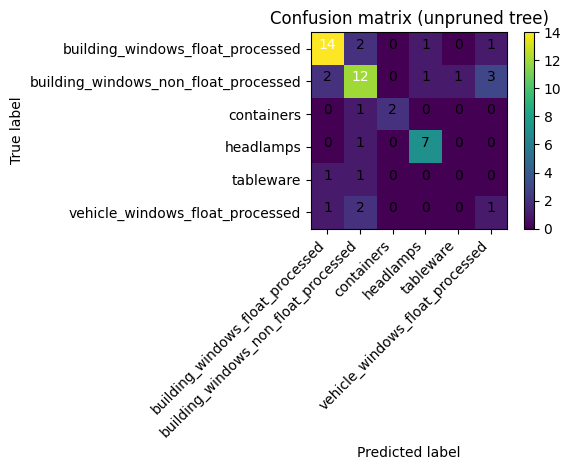

Tree depth: 10
Number of leaves: 39


In [6]:
# Train an (almost) unpruned tree
unpruned = DecisionTreeClassifier(random_state=RANDOM_STATE)
unpruned.fit(X_train, y_train)

train_pred = unpruned.predict(X_train)
test_pred = unpruned.predict(X_test)

print("Unpruned tree")
print("Train accuracy:", accuracy_score(y_train, train_pred))
print("Test accuracy :", accuracy_score(y_test, test_pred))
print("Train macro F1:", f1_score(y_train, train_pred, average="macro"))
print("Test macro F1 :", f1_score(y_test, test_pred, average="macro"))

cm = confusion_matrix(y_test, test_pred)
show_confusion(cm, class_names=class_names, title="Confusion matrix (unpruned tree)")

print("Tree depth:", unpruned.get_depth())
print("Number of leaves:", unpruned.get_n_leaves())


In [7]:
# Cost-complexity pruning path
path = unpruned.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas
impurities = path.impurities

len(ccp_alphas), (ccp_alphas.min(), ccp_alphas.max())


(29, (np.float64(0.0), np.float64(0.11415178571428564)))

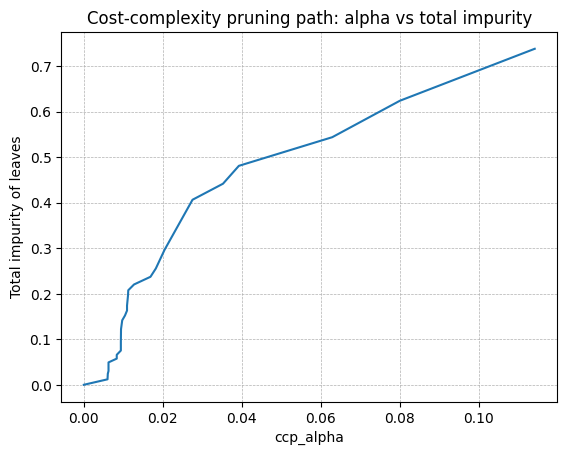

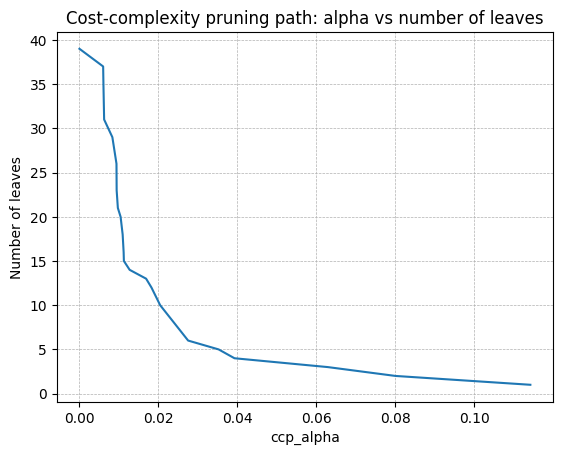

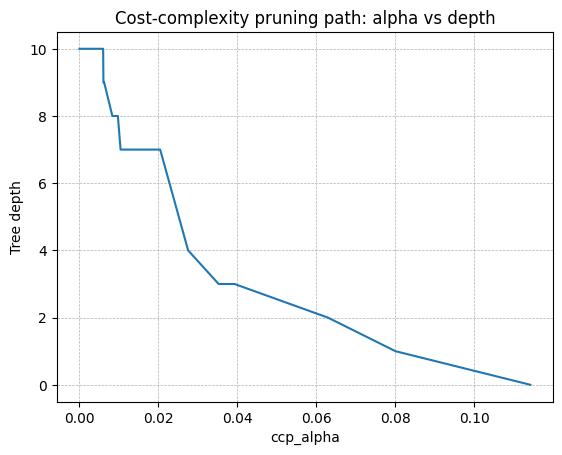

In [8]:
# Visualize pruning path: alpha vs impurity and alpha vs number of leaves
clfs = []
for a in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=RANDOM_STATE, ccp_alpha=a)
    clf.fit(X_train, y_train)
    clfs.append(clf)

node_counts = [c.tree_.node_count for c in clfs]
depths = [c.get_depth() for c in clfs]
leaves = [c.get_n_leaves() for c in clfs]

plt.figure()
plt.plot(ccp_alphas, impurities)
plt.xlabel("ccp_alpha")
plt.ylabel("Total impurity of leaves")
plt.title("Cost-complexity pruning path: alpha vs total impurity")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.show()

plt.figure()
plt.plot(ccp_alphas, leaves)
plt.xlabel("ccp_alpha")
plt.ylabel("Number of leaves")
plt.title("Cost-complexity pruning path: alpha vs number of leaves")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.show()

plt.figure()
plt.plot(ccp_alphas, depths)
plt.xlabel("ccp_alpha")
plt.ylabel("Tree depth")
plt.title("Cost-complexity pruning path: alpha vs depth")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.show()


### ۴.۱ انتخاب `ccp_alpha` با اعتبارسنجی متقاطع

یک روش پیش‌فرض خوب این است که alpha را طوری انتخاب کنیم که امتیاز اعتبارسنجی متقاطع بیشینه شود.

جزئیات مهم عملی:

- برای طبقه‌بندی از **StratifiedKFold** استفاده کنید.
- متریک را با هدف مسئله هماهنگ کنید (accuracy، macro F1 و غیره).
- alphaهای نزدیک صفر → درخت‌های بزرگ‌تر؛ alphaهای نزدیک بیشینه → درخت خیلی کوچک (stump).

در ادامه برای مجموعهٔ glass، امتیاز **macro F1** را در alphaهای مختلف محاسبه می‌کنیم و بهترین را انتخاب می‌کنیم.


In [9]:
# Cross-validate over candidate alphas (macro F1)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

alpha_scores = []
for a in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=RANDOM_STATE, ccp_alpha=a)
    scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring="f1_macro")
    alpha_scores.append(scores.mean())

alpha_scores = np.array(alpha_scores)
best_idx = int(np.argmax(alpha_scores))
best_alpha = float(ccp_alphas[best_idx])
best_alpha, float(alpha_scores[best_idx])


(0.02043269230769231, 0.6213799383936685)

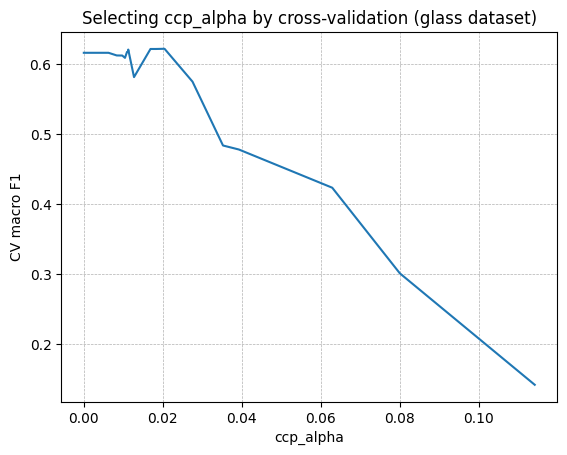

0.02043269230769231

In [10]:
# Plot alpha vs CV score
plt.figure()
plt.plot(ccp_alphas, alpha_scores)
plt.xlabel("ccp_alpha")
plt.ylabel("CV macro F1")
plt.title("Selecting ccp_alpha by cross-validation (glass dataset)")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.show()

best_alpha


Pruned tree (ccp_alpha = 0.020433)
Train accuracy: 0.8125
Test accuracy : 0.7592592592592593
Train macro F1: 0.7702308691619316
Test macro F1 : 0.609640522875817


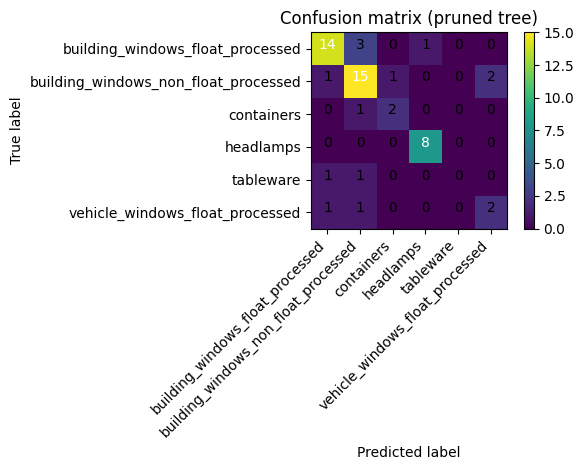

Tree depth: 7
Number of leaves: 10


In [11]:
# Train pruned tree with best_alpha and compare
pruned = DecisionTreeClassifier(random_state=RANDOM_STATE, ccp_alpha=best_alpha)
pruned.fit(X_train, y_train)

train_pred_p = pruned.predict(X_train)
test_pred_p = pruned.predict(X_test)

print("Pruned tree (ccp_alpha = %.6f)" % best_alpha)
print("Train accuracy:", accuracy_score(y_train, train_pred_p))
print("Test accuracy :", accuracy_score(y_test, test_pred_p))
print("Train macro F1:", f1_score(y_train, train_pred_p, average="macro"))
print("Test macro F1 :", f1_score(y_test, test_pred_p, average="macro"))

cm_p = confusion_matrix(y_test, test_pred_p)
show_confusion(cm_p, class_names=class_names, title="Confusion matrix (pruned tree)")

print("Tree depth:", pruned.get_depth())
print("Number of leaves:", pruned.get_n_leaves())


### ۴.۲ بررسی بصری: چند سطح ابتدایی درخت

نمایش کل درخت ممکن است بسیار شلوغ باشد. یک روش عملی این است که فقط چند سطح ابتدایی را با `max_depth` در `plot_tree` نمایش دهید.

ما نمایش می‌دهیم:
- نمای کم‌عمق از درخت **هرس‌نشده**.
- نمای کم‌عمق از درخت **هرس‌شده**.

هدف این قسمت «بهبود متریک» نیست؛ هدف، تفسیرپذیری و اطمینان از ساده‌تر شدن منطق تصمیم‌گیری است.


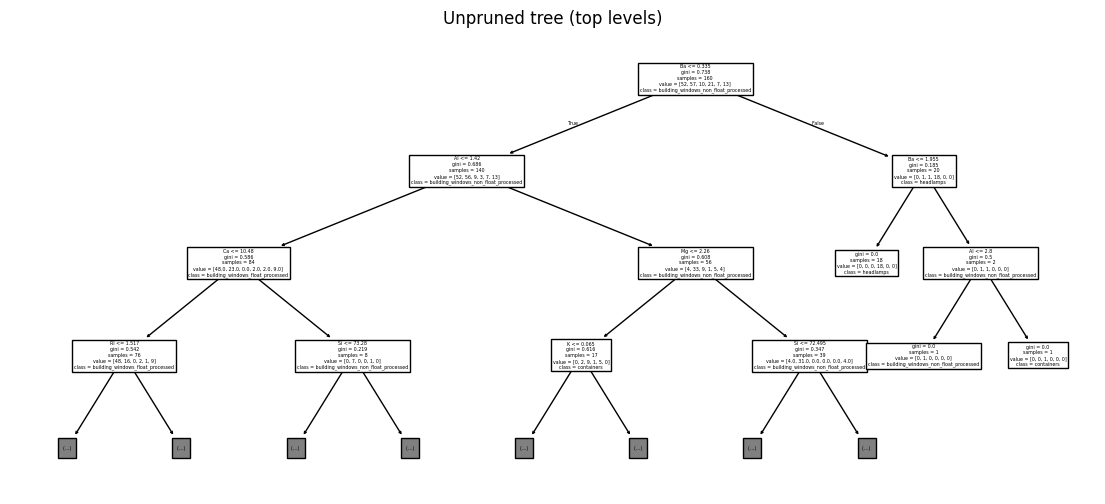

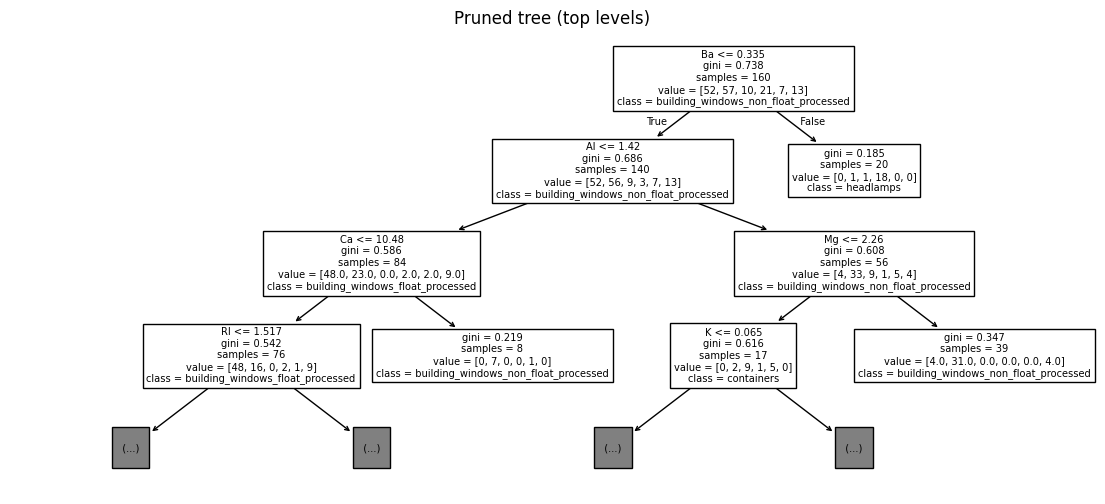

In [12]:
# Visualize the top part of both trees (limited depth)
plt.figure(figsize=(14, 6))
plot_tree(
    unpruned,
    feature_names=list(X.columns),
    class_names=class_names,
    max_depth=3,
    filled=False,
    impurity=True
)
plt.title("Unpruned tree (top levels)")
plt.show()

plt.figure(figsize=(14, 6))
plot_tree(
    pruned,
    feature_names=list(X.columns),
    class_names=class_names,
    max_depth=3,
    filled=False,
    impurity=True
)
plt.title("Pruned tree (top levels)")
plt.show()


## ۵) هرسِ پیشین در عمل: تنظیم کنترل‌های پیچیدگی

هرسِ پسین (`ccp_alpha`) قوی است، اما در بسیاری از پایپ‌لاین‌ها **هرسِ پیشین** ترجیح داده می‌شود چون با جست‌وجو بهتر ادغام می‌شود و زمان آموزش را کاهش می‌دهد.

در این بخش روی همان داده چند هایپرپارامتر اثرگذار را تنظیم می‌کنیم:

- `max_depth`
- `min_samples_leaf`
- `min_samples_split`
- `max_leaf_nodes`

### چرا این‌ها مهم‌اند؟

- `max_depth`: محدودیت مستقیم روی پیچیدگی.
- `min_samples_leaf`: جلوگیری از برگ‌های خیلی کوچک (کاهش واریانس).
- `min_samples_split`: جلوگیری از تقسیم گره‌های خیلی کوچک.
- `max_leaf_nodes`: کنترل مستقیم تعداد برگ‌ها.

برای دادهٔ glass از **macro F1** استفاده می‌کنیم تا عملکرد بین کلاس‌ها متوازن‌تر شود.


In [13]:
# Grid search for pre-pruning hyperparameters (glass dataset)
param_grid = {
    "max_depth": [2, 3, 4, 5, 6, 8, 10, None],
    "min_samples_leaf": [1, 2, 4, 8, 16],
    "min_samples_split": [2, 5, 10, 20],
    "max_leaf_nodes": [None, 5, 10, 20, 40]
}

base = DecisionTreeClassifier(random_state=RANDOM_STATE)

gs = GridSearchCV(
    estimator=base,
    param_grid=param_grid,
    scoring="f1_macro",
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),
    n_jobs=-1
)

gs.fit(X_train, y_train)

print("Best CV macro F1:", gs.best_score_)
print("Best params:", gs.best_params_)

best_prepruned = gs.best_estimator_
test_pred_best = best_prepruned.predict(X_test)

print("Test macro F1 :", f1_score(y_test, test_pred_best, average="macro"))
print("Test accuracy :", accuracy_score(y_test, test_pred_best))
print("Tree depth:", best_prepruned.get_depth())
print("Number of leaves:", best_prepruned.get_n_leaves())


Best CV macro F1: 0.6214499638847464
Best params: {'max_depth': 6, 'max_leaf_nodes': 20, 'min_samples_leaf': 2, 'min_samples_split': 2}
Test macro F1 : 0.5295123177476119
Test accuracy : 0.7037037037037037
Tree depth: 6
Number of leaves: 20


### ۵.۱ مقایسهٔ هرس‌نشده، هرسِ پسین و هرسِ پیشین

این موارد را خلاصه می‌کنیم:
- macro F1 روی آزمون
- accuracy روی آزمون
- عمق درخت
- تعداد برگ‌ها

در عمل معمولاً «ساده‌ترین مدلی که معیار هدف را برآورده می‌کند» گزینهٔ بهتر و پایدارتر است.


In [14]:
# Compare three models
def summarize_classifier(model, X_train, y_train, X_test, y_test, name):
    tr = model.predict(X_train)
    te = model.predict(X_test)
    return {
        "model": name,
        "train_acc": accuracy_score(y_train, tr),
        "test_acc": accuracy_score(y_test, te),
        "train_f1_macro": f1_score(y_train, tr, average="macro"),
        "test_f1_macro": f1_score(y_test, te, average="macro"),
        "depth": model.get_depth(),
        "leaves": model.get_n_leaves()
    }

rows = [
    summarize_classifier(unpruned, X_train, y_train, X_test, y_test, "Unpruned"),
    summarize_classifier(pruned, X_train, y_train, X_test, y_test, "Post-pruned (ccp_alpha)"),
    summarize_classifier(best_prepruned, X_train, y_train, X_test, y_test, "Pre-pruned (GridSearch)"),
]

pd.DataFrame(rows)


,model,train_acc,test_acc,train_f1_macro,test_f1_macro,depth,leaves
0,Unpruned,1.00000,0.666667,1.000000,0.542518,10,39
1,Post-pruned (ccp_alpha),0.81250,0.759259,0.770231,0.609641,7,10
2,Pre-pruned (GridSearch),0.85625,0.703704,0.851816,0.529512,6,20


## ۶) تشخیص بیش‌برازش با نمودارها (دادهٔ diabetes)

امتیاز روی یک split می‌تواند نویزی باشد. نمودارها تشخیص دقیق‌تری می‌دهند.

در این بخش از `diabetes.csv` (طبقه‌بندی دودویی) استفاده می‌کنیم و می‌بینیم:

1. **منحنی اعتبارسنجی**: امتیاز بر حسب `max_depth`.
2. **منحنی یادگیری**: امتیاز بر حسب اندازهٔ دادهٔ آموزش.

### ۶.۱ ایدهٔ منحنی اعتبارسنجی

اگر درخت بیش‌برازش کند، معمولاً:
- امتیاز آموزش بسیار بالا
- امتیاز اعتبارسنجی پایین‌تر و در پیچیدگی زیاد رو به کاهش

### ۶.۲ ایدهٔ منحنی یادگیری

با افزایش داده:
- اگر امتیاز اعتبارسنجی بهتر شود → احتمالاً دادهٔ بیشتر کمک می‌کند.
- اگر آموزش و اعتبارسنجی هر دو پایین باشند → کم‌برازش (سوگیری بالا).
- اگر آموزش بالا و اعتبارسنجی پایین باشد → بیش‌برازش (واریانس بالا) و نیاز به هرس/منظم‌سازی.


In [15]:
# Load diabetes dataset
dia_path = "../../../Datasets/Classification/diabetes.csv"
dia = pd.read_csv(dia_path)

dia.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,classification
0,6,148,72,35,0,33.6,0.627,50,Diabetic
1,1,85,66,29,0,26.6,0.351,31,Non-Diabetic
2,8,183,64,0,0,23.3,0.672,32,Diabetic
3,1,89,66,23,94,28.1,0.167,21,Non-Diabetic
4,0,137,40,35,168,43.1,2.288,33,Diabetic


In [16]:
# Prepare diabetes features/target
target_col = "classification"
X_d = dia.drop(columns=[target_col])
y_d = dia[target_col].astype(str)

le_d = LabelEncoder()
y_d_enc = le_d.fit_transform(y_d)

X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(
    X_d, y_d_enc, test_size=0.25, random_state=RANDOM_STATE, stratify=y_d_enc
)

le_d.classes_


array(['Diabetic', 'Non-Diabetic'], dtype=object)

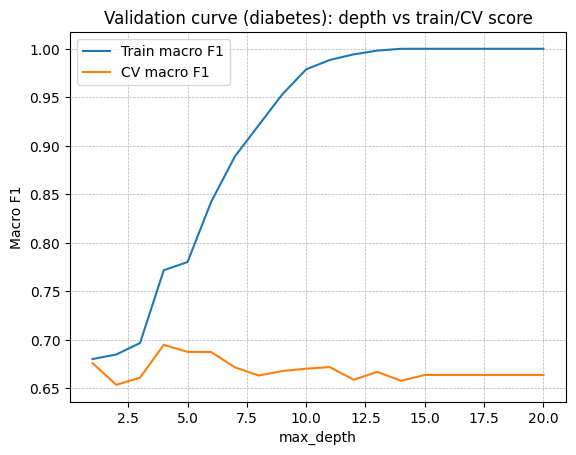

4

In [17]:
# Validation curve: max_depth vs CV score (macro F1) + train score
depths = list(range(1, 21))
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

train_scores = []
cv_scores = []

for d in depths:
    clf = DecisionTreeClassifier(max_depth=d, random_state=RANDOM_STATE)
    # Compute CV score
    scores = cross_val_score(clf, X_train_d, y_train_d, cv=cv, scoring="f1_macro")
    cv_scores.append(scores.mean())
    # Fit on full train split for training score
    clf.fit(X_train_d, y_train_d)
    train_scores.append(f1_score(y_train_d, clf.predict(X_train_d), average="macro"))

plt.figure()
plt.plot(depths, train_scores, label="Train macro F1")
plt.plot(depths, cv_scores, label="CV macro F1")
plt.xlabel("max_depth")
plt.ylabel("Macro F1")
plt.title("Validation curve (diabetes): depth vs train/CV score")
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.5)
plt.show()

best_depth = depths[int(np.argmax(cv_scores))]
best_depth


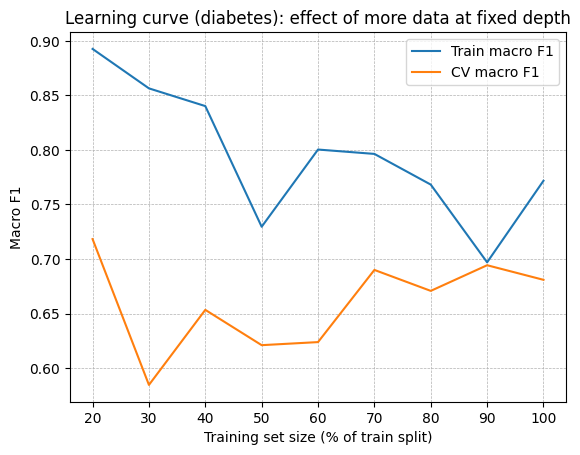

4

In [18]:
# Learning curve (manual): train size vs CV score for a fixed depth
fixed_depth = int(best_depth)
sizes = np.linspace(0.2, 1.0, 9)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
cv_means = []
train_means = []

n = X_train_d.shape[0]
idx = np.arange(n)

for frac in sizes:
    m = int(max(50, frac * n))
    sub_idx = np.random.choice(idx, size=m, replace=False)
    X_sub = X_train_d.iloc[sub_idx]
    y_sub = y_train_d[sub_idx]

    # CV on subset
    clf = DecisionTreeClassifier(max_depth=fixed_depth, random_state=RANDOM_STATE)
    scores = cross_val_score(clf, X_sub, y_sub, cv=cv, scoring="f1_macro")
    cv_means.append(scores.mean())

    # Train score on subset
    clf.fit(X_sub, y_sub)
    train_means.append(f1_score(y_sub, clf.predict(X_sub), average="macro"))

plt.figure()
plt.plot((sizes * 100).astype(int), train_means, label="Train macro F1")
plt.plot((sizes * 100).astype(int), cv_means, label="CV macro F1")
plt.xlabel("Training set size (% of train split)")
plt.ylabel("Macro F1")
plt.title("Learning curve (diabetes): effect of more data at fixed depth")
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.5)
plt.show()

fixed_depth


## ۷) درخت‌های رگرسیون: هرس برای هدف عددی (`house-prices.csv`)

هرس برای درخت‌های رگرسیون هم حیاتی است. درخت رگرسیون عمیق می‌تواند نویز آموزش را حفظ کند و RMSE آزمون را افزایش دهد.

گام‌ها:
1. خواندن `house-prices.csv`.
2. ساخت پایپ‌لاین پیش‌پردازش (ستونی برای دسته‌ای + عددی).
3. آموزش یک `DecisionTreeRegressor` عمیق و محاسبهٔ RMSE/R².
4. استفاده از `ccp_alpha` و اعتبارسنجی متقاطع برای انتخاب زیر‌درخت هرس‌شده.


In [19]:
# Load house prices dataset
house_path = "../../../Datasets/Regression/house-prices.csv"
house = pd.read_csv(house_path)

house.head()


,Home,Price,SqFt,Bedrooms,Bathrooms,Offers,Brick,Neighborhood
0,1,114300,1790,2,2,2,No,East
1,2,114200,2030,4,2,3,No,East
2,3,114800,1740,3,2,1,No,East
3,4,94700,1980,3,2,3,No,East
4,5,119800,2130,3,3,3,No,East


In [20]:
# Prepare regression target and features
target_col = "Price"
X_h = house.drop(columns=[target_col])
y_h = house[target_col].astype(float)

# Identify categorical vs numeric columns
cat_cols = [c for c in X_h.columns if X_h[c].dtype == "object"]
num_cols = [c for c in X_h.columns if c not in cat_cols]

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols),
    ]
)

X_train_h, X_test_h, y_train_h, y_test_h = train_test_split(
    X_h, y_h, test_size=0.25, random_state=RANDOM_STATE
)

cat_cols, num_cols, X_train_h.shape


(['Brick', 'Neighborhood'],
 ['Home', 'SqFt', 'Bedrooms', 'Bathrooms', 'Offers'],
 (96, 7))

In [21]:
# Deep regression tree (baseline)
reg_unpruned = Pipeline(
    steps=[
        ("prep", preprocess),
        ("model", DecisionTreeRegressor(random_state=RANDOM_STATE))
    ]
)

reg_unpruned.fit(X_train_h, y_train_h)

pred_tr = reg_unpruned.predict(X_train_h)
pred_te = reg_unpruned.predict(X_test_h)

print("Unpruned regression tree")
print("Train RMSE:", rmse(y_train_h, pred_tr))
print("Test RMSE :", rmse(y_test_h, pred_te))
print("Train R2  :", r2_score(y_train_h, pred_tr))
print("Test R2   :", r2_score(y_test_h, pred_te))


Unpruned regression tree
Train RMSE: 0.0
Test RMSE : 20189.732848653544
Train R2  : 1.0
Test R2   : 0.3350504111430076


In [22]:
# Compute pruning path for regression tree
# Note: we need the transformed numeric array for pruning_path on the underlying tree model.
Xt = preprocess.fit_transform(X_train_h)
base_reg = DecisionTreeRegressor(random_state=RANDOM_STATE)
base_reg.fit(Xt, y_train_h)

path = base_reg.cost_complexity_pruning_path(Xt, y_train_h)
ccp_alphas = path.ccp_alphas
impurities = path.impurities

len(ccp_alphas), (ccp_alphas.min(), ccp_alphas.max())


(90, (np.float64(0.0), np.float64(373394205.25568295)))

In [23]:
# Cross-validate over ccp_alpha values for regression (RMSE)
cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

alpha_rmse = []
for a in ccp_alphas:
    model = Pipeline(
        steps=[
            ("prep", preprocess),
            ("model", DecisionTreeRegressor(random_state=RANDOM_STATE, ccp_alpha=a))
        ]
    )
    # Use negative MSE because cross_val_score expects higher is better
    neg_mse = cross_val_score(model, X_train_h, y_train_h, cv=cv, scoring="neg_mean_squared_error")
    alpha_rmse.append(np.sqrt(-neg_mse.mean()))

alpha_rmse = np.array(alpha_rmse)
best_idx = int(np.argmin(alpha_rmse))
best_alpha_reg = float(ccp_alphas[best_idx])
best_alpha_reg, float(alpha_rmse[best_idx])


(12450948.822464164, 17010.1916057516)

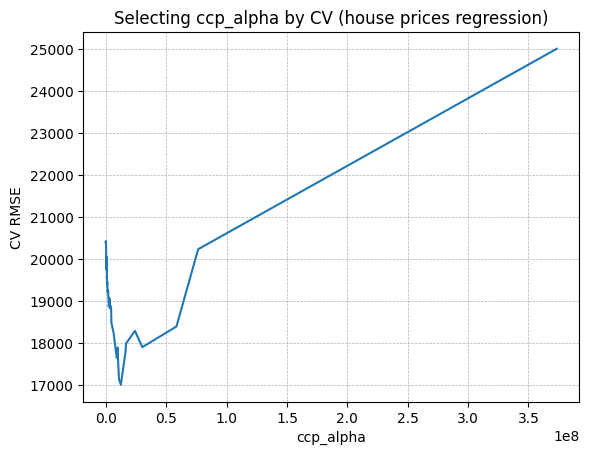

12450948.822464164

In [24]:
# Plot alpha vs CV RMSE
plt.figure()
plt.plot(ccp_alphas, alpha_rmse)
plt.xlabel("ccp_alpha")
plt.ylabel("CV RMSE")
plt.title("Selecting ccp_alpha by CV (house prices regression)")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.show()

best_alpha_reg


In [25]:
# Fit pruned regression tree and compare
reg_pruned = Pipeline(
    steps=[
        ("prep", preprocess),
        ("model", DecisionTreeRegressor(random_state=RANDOM_STATE, ccp_alpha=best_alpha_reg))
    ]
)

reg_pruned.fit(X_train_h, y_train_h)

pred_tr_p = reg_pruned.predict(X_train_h)
pred_te_p = reg_pruned.predict(X_test_h)

print("Pruned regression tree (ccp_alpha = %.6f)" % best_alpha_reg)
print("Train RMSE:", rmse(y_train_h, pred_tr_p))
print("Test RMSE :", rmse(y_test_h, pred_te_p))
print("Train R2  :", r2_score(y_train_h, pred_tr_p))
print("Test R2   :", r2_score(y_test_h, pred_te_p))


Pruned regression tree (ccp_alpha = 12450948.822464)
Train RMSE: 12220.44070859667
Test RMSE : 15842.380911890095
Train R2  : 0.7995548437997928
Test R2   : 0.5905805415949494


## ۸) راهنمای عملی و خطاهای رایج

### ۸.۱ چه زمانی هرس کنیم؟

- اگر امتیاز آموزش تقریباً کامل و امتیاز اعتبارسنجی بسیار پایین‌تر باشد → هرس/منظم‌سازی لازم است.
- اگر آموزش و اعتبارسنجی هر دو ضعیف باشند → هرس احتمالاً بدتر می‌کند؛ شاید به ویژگی بهتر، مدل دیگر یا سیگنال بیشتر نیاز دارید.

### ۸.۲ اعتبارسنجی متقاطع و جلوگیری از نشت داده

به‌دلیل حساسیت درخت‌ها، ارزیابی باید پایدار باشد:
- برای انتخاب `ccp_alpha` یا پارامترهای هرسِ پیشین از **CV** استفاده کنید.
- یک مجموعهٔ آزمون نهایی را دست‌نخورده نگه دارید.

نشت‌های رایج:
- استفادهٔ مکرر از آزمون هنگام تنظیم پارامترها.
- انجام پیش‌پردازش روی کل داده قبل از split (در بخش رگرسیون از پایپ‌لاین استفاده کردیم).

### ۸.۳ انتخاب متریک

- طبقه‌بندی دودویی: accuracy، F1، ROC-AUC (اینجا AUC را پیاده نکردیم).
- چندکلاسه: macro F1 معمولاً از accuracy بهتر است اگر عدم‌توازن وجود داشته باشد.
- رگرسیون: RMSE، MAE، R².

### ۸.۴ بررسی پایداری (اختیاری ولی توصیه‌شده)

درخت‌ها می‌توانند ناپایدار باشند. تمرین‌های خوب:
- CV تکرارشونده یا چند seed مختلف.
- گزارش میانگین و انحراف معیار امتیازها.
- اگر پایداری مهم است، استفاده از ensembleها (Random Forest / Gradient Boosting).


## ۹) تمرین‌ها (با پاسخ پیشنهادی)

### تمرین ۱ — مفهومی: چرا هرس کمک می‌کند؟
**سؤال:** چرا کم کردن تعداد برگ‌ها می‌تواند عملکرد آزمون را بهتر کند؟

**پاسخ پیشنهادی:** چون با کاهش برگ‌ها، واریانس مدل کم می‌شود و درخت کمتر می‌تواند روی نویزِ نواحی کوچک فیت شود. هرس کمی سوگیری را بالا می‌برد، اما معمولاً کاهش واریانس غالب است و تعمیم بهتر می‌شود.

---

### تمرین ۲ — قانون انتخاب سفارشی برای `ccp_alpha`
**کار:** در بخش glass، کوچک‌ترین `ccp_alpha` را انتخاب کنید که امتیاز CV آن حداکثر «یک انحراف معیار» کمتر از بهترین امتیاز باشد (قانون one-standard-error).

**راهنما:** میانگین و انحراف معیار امتیازهای CV را برای هر alpha ذخیره کنید، سپس ساده‌ترین مدل نزدیک به بهترین را انتخاب کنید.

---

### تمرین ۳ — مقایسهٔ هرسِ پیشین و پسین روی diabetes
**کار:** روی دادهٔ diabetes:
1. یک `max_depth` مناسب با منحنی اعتبارسنجی پیدا کنید.
2. یک `ccp_alpha` مناسب با مسیر هرس و CV پیدا کنید.
3. macro F1 آزمون و اندازهٔ درخت را مقایسه کنید.

**انتظار:** هر دو روش می‌توانند خوب باشند؛ گاهی هرسِ پیچیدگی-هزینه درخت ساده‌تری با امتیاز مشابه می‌دهد.

---

### تمرین ۴ — رگرسیون: تفسیر ناپایداری
**کار:** برای خانه‌ها، CV را با چند seed مختلف اجرا کنید و تغییرات بهترین `ccp_alpha` را گزارش کنید. چه می‌بینید؟

**پاسخ پیشنهادی:** بهترین alpha ممکن است بین splitها تغییر کند چون درخت‌ها ناپایدارند. این طبیعی است و با CV تکرارشونده یا ensembleها بهتر می‌شود.

---

### تمرین ۵ — عمیق‌تر: هدف هرس
**سؤال:** عبارت
$$
R_\alpha(T) = R(T) + \alpha |T|
$$
را به زبان ساده تفسیر کنید.

**پاسخ پیشنهادی:** کیفیت فیت (کم بودن $R(T)$) را در برابر سادگی مدل (کوچک بودن $|T|$) مبادله می‌کنیم. هرچه $\alpha$ بزرگ‌تر باشد، جریمهٔ پیچیدگی بیشتر و درخت کوچک‌تر می‌شود.


## ۱۰) جمع‌بندی

- درخت‌های تصمیم به‌راحتی بیش‌برازش می‌کنند چون **واریانس بالا** دارند و داده را به برگ‌های کوچک خرد می‌کنند.
- **هرسِ پیشین** رشد را محدود می‌کند (عمق، حداقل نمونه، حداکثر برگ).
- **هرسِ پسین** (پیچیدگی-هزینه) درخت بزرگ را با `ccp_alpha` کوچک می‌کند.
- برای انتخاب شدت هرس از **اعتبارسنجی متقاطع** استفاده کنید.
- با **منحنی اعتبارسنجی** و **منحنی یادگیری** بهتر تشخیص می‌دهید.
- هرس برای هر دو نوع **طبقه‌بندی** و **رگرسیون** مهم است.

در درس‌های بعدی (مثل CHAID، C4.5/C5.0، مدل‌درخت‌ها و ensembleها) همین ایدهٔ کنترل پیچیدگی نقش کلیدی دارد.


# پیوست‌ها (مطالعهٔ عمیق‌تر)

محتوای اصلی بالا برای استفادهٔ عملی از هرس کافی است. پیوست‌های زیر عمق بیشتری برای درک دانشگاهی فراهم می‌کنند: شهود رسمی‌تر، تعامل پارامترها و پروتکل‌های ارزیابی مقاوم.

همهٔ فرمول‌ها در این نوت‌بوک با $...$ و $$...$$ نوشته شده‌اند.


## پیوست A — سوگیری–واریانس و اینکه چرا درخت‌ها «ماشین واریانس» هستند

برای رگرسیون با زیان مربعی، تجزیهٔ کلاسیک به شکل زیر است:
$$
\mathbb{E}[(y-\hat f(x))^2] = \underbrace{\text{Bias}(\hat f)^2}_{\text{خطای سیستماتیک}} + \underbrace{\text{Var}(\hat f)}_{\text{حساسیت به داده}} + \underbrace{\sigma^2}_{\text{نویزِ غیرقابل حذف}}.
$$

درخت‌های تصمیم (به‌خصوص درخت‌های هرس‌نشده) معمولاً سوگیری کمی روی دادهٔ آموزش دارند چون می‌توانند آن‌قدر تقسیم کنند تا برگ‌ها تقریباً خالص شوند (یا برای رگرسیون تقریباً ثابت). اما این انعطاف هزینه دارد: **واریانس**. یک تغییر کوچک در دادهٔ آموزش می‌تواند یک تقسیم اولیه را عوض کند و با تغییر تقسیم اولیه، کل ساختار زیر‌درخت تغییر می‌کند. به همین دلیل درخت‌های عمیق اغلب ناپایدارند.

یک شاخص عملی برای واریانس، نگاه کردن به **اندازهٔ برگ‌ها** است. اگر بسیاری از برگ‌ها فقط ۱ تا ۳ نمونه داشته باشند، پیش‌بینی برگ بیشتر تحت تاثیر نویز نمونه‌گیری است. شاخص دوم **اندازهٔ مدل** است (عمق و تعداد برگ‌ها): درخت‌های خیلی بزرگ روی داده‌های جدولی معمولاً بیش‌برازش می‌کنند مگر اینکه تعداد نمونه‌ها بسیار زیاد باشد.

در طبقه‌بندی، برای همهٔ متریک‌ها یک تجزیهٔ سوگیری–واریانس به آن سادگی نداریم، اما شهود برقرار است: درخت‌های عمیق انعطاف‌پذیر و حساس‌اند. به همین دلیل هرس پیشین و هرس پسین ابزارهای منظم‌سازی اصلی درخت‌ها هستند.



## پیوست B — هرسِ پیچیدگی-هزینه: فرمول «ضعیف‌ترین پیوند»

در هرس به سبک CART، هر گره داخلی $t$ یک زیر‌درخت $T_t$ (گره و همهٔ فرزندان) دارد. اگر در $t$ هرس کنیم، $T_t$ را با یک برگ جایگزین می‌کنیم. کمیت کلیدی، **alpha مؤثر** است که نشان می‌دهد به ازای حذف هر برگ، تابع هدف چقدر بدتر می‌شود.

یک تعریف رایج (از دید مفهومی) این است:
$$
\alpha(t) = \frac{R(t) - R(T_t)}{|T_t| - 1},
$$
که در آن:
- $R(T_t)$ ناخالصی/خطای آموزش زیر‌درخت است،
- $R(t)$ ناخالصی/خطا اگر زیر‌درخت به یک برگ تبدیل شود،
- $|T_t|$ تعداد برگ‌های زیر‌درخت است.

تفسیر: $\alpha(t)$ «قیمت» افزایش خطا به ازای حذف هر برگ است. الگوریتم ابتدا زیر‌درختی را که کمترین $\alpha(t)$ را دارد هرس می‌کند (ضعیف‌ترین پیوند)، و یک دنباله از زیر‌درخت‌ها می‌سازد. سپس با CV انتخاب می‌کنیم کدام زیر‌درخت تعمیم بهتری دارد.

در scikit-learn، `cost_complexity_pruning_path` مقادیر کاندید `ccp_alpha` و ناخالصی‌های متناظر را می‌دهد، اما هنوز باید با یک روش اعتبارسنجی (CV) مقدار مناسب را انتخاب کنید.



## پیوست C — پروتکل انتخاب مدل مقاوم (Nested CV)

یک اشتباه رایج این است که هایپرپارامترها را بارها با استفاده از مجموعهٔ آزمون تنظیم کنیم. این کار برآورد عملکرد را بیش‌ازحد خوش‌بینانه می‌کند.

پروتکل مقاوم، **اعتبارسنجی متقاطع تو در تو** است:
1. حلقهٔ بیرونی داده را به foldهای train/test تقسیم می‌کند (برای برآورد بی‌طرفانه).
2. حلقهٔ درونی انتخاب هایپرپارامتر را انجام می‌دهد (مثلاً انتخاب `ccp_alpha` یا `max_depth`).
3. توزیع امتیازهای حلقهٔ بیرونی را گزارش می‌کنیم (میانگین ± انحراف معیار).

شبه‌کد:
- CV بیرونی: برای هر split بیرونی
  - CV درونی: انتخاب پارامترها فقط روی بخش آموزش
  - آموزش مدل با پارامترهای انتخاب‌شده روی کل آموزش بیرونی
  - ارزیابی روی آزمون بیرونی

وقتی داده کوچک است، nested CV معیار طلایی برای برآورد تعمیم در حضور tuning است.


## پیوست D.1 — الگوهای رایج بیش‌برازش در درخت‌ها

- **برگ‌های بسیار کوچک (۱ تا ۳ نمونه)**
  - چرا مهم است: برگ‌های بسیار کوچک (۱ تا ۳ نمونه) یکی از دلایل رایج خطای تعمیم در درخت‌هاست اگر کنترل نشود.
  - نشانهٔ عملی: معمولاً با زیاد شدن فاصلهٔ آموزش–اعتبارسنجی یا ناپایداری تقسیم‌ها دیده می‌شود.
  - راهکار: از هرس پیشین (محدودیت عمق/برگ) و/یا هرس پسین (`ccp_alpha`) با CV استفاده کنید.
  - راستی‌آزمایی: بهبود را با CV تکرارشونده و همچنین اندازهٔ درخت (عمق/تعداد برگ) بررسی کنید.

- **درخت‌های بسیار عمیق با امتیاز آموزش تقریباً کامل**
  - چرا مهم است: درخت‌های بسیار عمیق با امتیاز آموزش تقریباً کامل یکی از دلایل رایج خطای تعمیم در درخت‌هاست اگر کنترل نشود.
  - نشانهٔ عملی: معمولاً با زیاد شدن فاصلهٔ آموزش–اعتبارسنجی یا ناپایداری تقسیم‌ها دیده می‌شود.
  - راهکار: از هرس پیشین (محدودیت عمق/برگ) و/یا هرس پسین (`ccp_alpha`) با CV استفاده کنید.
  - راستی‌آزمایی: بهبود را با CV تکرارشونده و همچنین اندازهٔ درخت (عمق/تعداد برگ) بررسی کنید.

- **حساسیت زیاد به seed / split**
  - چرا مهم است: حساسیت زیاد به seed / split یکی از دلایل رایج خطای تعمیم در درخت‌هاست اگر کنترل نشود.
  - نشانهٔ عملی: معمولاً با زیاد شدن فاصلهٔ آموزش–اعتبارسنجی یا ناپایداری تقسیم‌ها دیده می‌شود.
  - راهکار: از هرس پیشین (محدودیت عمق/برگ) و/یا هرس پسین (`ccp_alpha`) با CV استفاده کنید.
  - راستی‌آزمایی: بهبود را با CV تکرارشونده و همچنین اندازهٔ درخت (عمق/تعداد برگ) بررسی کنید.

- **اهمیت زیاد برای ویژگی‌های مشکوک**
  - چرا مهم است: اهمیت زیاد برای ویژگی‌های مشکوک یکی از دلایل رایج خطای تعمیم در درخت‌هاست اگر کنترل نشود.
  - نشانهٔ عملی: معمولاً با زیاد شدن فاصلهٔ آموزش–اعتبارسنجی یا ناپایداری تقسیم‌ها دیده می‌شود.
  - راهکار: از هرس پیشین (محدودیت عمق/برگ) و/یا هرس پسین (`ccp_alpha`) با CV استفاده کنید.
  - راستی‌آزمایی: بهبود را با CV تکرارشونده و همچنین اندازهٔ درخت (عمق/تعداد برگ) بررسی کنید.

- **شکاف بزرگ آموزش–اعتبارسنجی در منحنی‌ها**
  - چرا مهم است: شکاف بزرگ آموزش–اعتبارسنجی در منحنی‌ها یکی از دلایل رایج خطای تعمیم در درخت‌هاست اگر کنترل نشود.
  - نشانهٔ عملی: معمولاً با زیاد شدن فاصلهٔ آموزش–اعتبارسنجی یا ناپایداری تقسیم‌ها دیده می‌شود.
  - راهکار: از هرس پیشین (محدودیت عمق/برگ) و/یا هرس پسین (`ccp_alpha`) با CV استفاده کنید.
  - راستی‌آزمایی: بهبود را با CV تکرارشونده و همچنین اندازهٔ درخت (عمق/تعداد برگ) بررسی کنید.


## پیوست D — تفسیر اهمیت ویژگی با احتیاط

اهمیت ویژگی درخت (`feature_importances_`) بر اساس مجموع کاهش ناخالصی است و می‌تواند گمراه‌کننده باشد وقتی:
- ویژگی‌ها هم‌بسته‌اند (اهمیت بین آن‌ها تقسیم یا به‌صورت دلخواه توزیع می‌شود)،
- ویژگی‌های با کاردینالیتی بالا نقاط تقسیم زیادی دارند،
- درخت خیلی عمیق و بیش‌برازش است (اهمیت بازتاب تقسیم‌های نویزی می‌شود).

یک تشخیص قوی‌تر، **اهمیت جایگشت (Permutation Importance)** روی دادهٔ اعتبارسنجی است:
1. امتیاز پایه را حساب کنید.
2. برای هر ویژگی، آن ستون را تصادفی جایگشت دهید و امتیاز را دوباره حساب کنید.
3. افت زیاد یعنی مدل به آن ویژگی اتکا داشته است.

Permutation importance کندتر است، اما برای بررسی پس‌نگر معمولاً قابل اعتمادتر است.


In [26]:
# Helper (safety): define plot_feature_importances if not defined
import numpy as np
import matplotlib.pyplot as plt

def plot_feature_importances(importances, feature_names, top_k=15, title="Feature importances"):
    order = np.argsort(importances)[::-1][:top_k]
    plt.figure()
    plt.bar(np.arange(len(order)), importances[order])
    plt.xticks(np.arange(len(order)), [feature_names[i] for i in order], rotation=45, ha="right")
    plt.ylabel("Importance")
    plt.title(title)
    plt.tight_layout()
    plt.show()


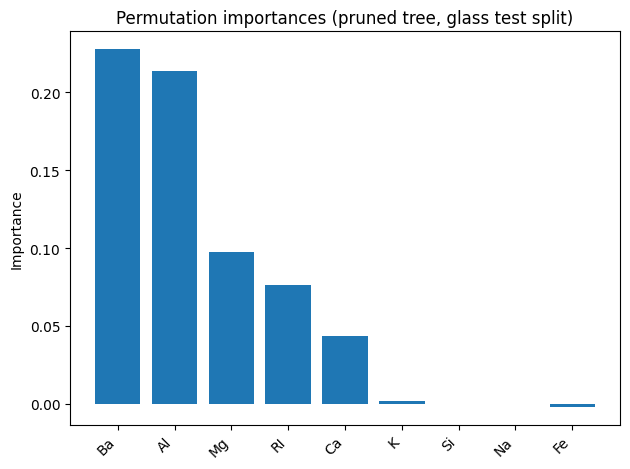

In [27]:
# Permutation importance example (glass dataset, pruned model)
from sklearn.inspection import permutation_importance

# Use the pruned tree and the held-out test split created earlier
result = permutation_importance(
    pruned, X_test, y_test,
    n_repeats=15,
    random_state=RANDOM_STATE,
    scoring="f1_macro"
)

importances = result.importances_mean
plot_feature_importances(importances, feature_names=list(X.columns), top_k=min(15, X.shape[1]),
                         title="Permutation importances (pruned tree, glass test split)")



## پیوست E — زمانی که هرس مشکل را حل نمی‌کند

هرس واریانس را کنترل می‌کند، اما نمی‌تواند سیگنالی را که وجود ندارد خلق کند. حالت‌های شکست رایج:

- **کم‌برازش**: امتیاز آموزش و اعتبارسنجی هر دو پایین‌اند. هرس معمولاً بدتر می‌کند. به ویژگی بهتر، تعامل‌ها یا خانوادهٔ مدل دیگر فکر کنید.
- **نویز برچسب**: وقتی برچسب‌ها ناسازگارند، درخت می‌تواند الگوهای کاذب را یاد بگیرد. هرس کمی کمک می‌کند، اما پاک‌سازی برچسب‌ها اغلب اثر بیشتری دارد.
- **نشت داده**: اگر ویژگی‌ای نتیجه را لو بدهد (ویژگی‌های پس از رخداد)، ممکن است امتیازهای عالی ببینید که در محصول فرو می‌ریزند. هرس نشت را حل نمی‌کند؛ ممیزی ویژگی لازم است.
- **تغییر توزیع**: اگر توزیع آموزش و استقرار فرق کند، بهترین alpha در CV ممکن است بعداً بهترین نباشد. به پایش و بازاعتبارسنجی دوره‌ای نیاز دارید.

عادت عملی خوب: هرس را همیشه با ارزیابی سخت‌گیرانه و sanity check روی ویژگی‌ها و splitها همراه کنید.



## پیوست F — تمرین‌های اضافه (بدون پاسخ)

1. روی دادهٔ glass، nested CV برای انتخاب `ccp_alpha` پیاده‌سازی کنید و macro F1 را به صورت میانگین ± انحراف معیار گزارش کنید.
2. برای diabetes، `class_weight="balanced"` را اضافه کنید و (الف) تنظیم عمق، (ب) هرس alpha را مقایسه کنید.
3. برای house prices، RMSE سه حالت unpruned، alpha-pruned و pre-pruned را مقایسه کنید و اندازهٔ مدل را هم گزارش کنید.
4. درخت را با RandomForest جایگزین کنید و پایداری (انحراف معیار امتیاز CV) را با یک درخت هرس‌شده مقایسه کنید.


## پیوست G — برگهٔ تقلب پارامترهای هرس و هرسِ پیشین

در ادامه یک راهنمای فشرده ولی کاربردی برای مهم‌ترین پارامترهای منظم‌سازی درخت آمده است. هنگام tuning از آن به‌عنوان مرجع سریع استفاده کنید.

### `max_depth`

سقف سخت روی تعداد سطوح تقسیم. مقدار کمتر واریانس را کاهش می‌دهد و تفسیرپذیری را بالا می‌برد، اما ممکن است کم‌برازش ایجاد کند.

الگوی رایج تنظیم:
- یک grid کوچک و درشت شروع کنید.
- روی متریک هدف با CV امتیاز بگیرید.
- اگر عملکرد نزدیک است، تنظیم ساده‌تر را ترجیح دهید (قانون یک انحراف معیار).

خطای رایج:
- تنظیم این پارامتر با استفاده از مجموعهٔ آزمون (نشت).

### `min_samples_leaf`

حداقل نمونه در هر برگ. افزایش آن مستقیماً جلوی برگ‌های بسیار کوچک را می‌گیرد و معمولاً قوی‌ترین کاهش‌دهندهٔ واریانس است.

الگوی رایج تنظیم:
- یک grid کوچک و درشت شروع کنید.
- روی متریک هدف با CV امتیاز بگیرید.
- اگر عملکرد نزدیک است، تنظیم ساده‌تر را ترجیح دهید (قانون یک انحراف معیار).

خطای رایج:
- تنظیم این پارامتر با استفاده از مجموعهٔ آزمون (نشت).

### `min_samples_split`

حداقل نمونه برای تقسیم یک گره. جلوی تقسیم گره‌های خیلی کوچک را می‌گیرد و با min_samples_leaf تعامل دارد.

الگوی رایج تنظیم:
- یک grid کوچک و درشت شروع کنید.
- روی متریک هدف با CV امتیاز بگیرید.
- اگر عملکرد نزدیک است، تنظیم ساده‌تر را ترجیح دهید (قانون یک انحراف معیار).

خطای رایج:
- تنظیم این پارامتر با استفاده از مجموعهٔ آزمون (نشت).

### `max_leaf_nodes`

محدودیت صریح روی تعداد برگ‌ها. وقتی بودجهٔ اندازهٔ مدل دارید (استقرار/ممیزی) بسیار مفید است.

الگوی رایج تنظیم:
- یک grid کوچک و درشت شروع کنید.
- روی متریک هدف با CV امتیاز بگیرید.
- اگر عملکرد نزدیک است، تنظیم ساده‌تر را ترجیح دهید (قانون یک انحراف معیار).

خطای رایج:
- تنظیم این پارامتر با استفاده از مجموعهٔ آزمون (نشت).

### `min_impurity_decrease`

تقسیم فقط اگر کاهش ناخالصی حداقل این مقدار باشد. شبیه آستانهٔ توقف زودهنگام عمل می‌کند.

الگوی رایج تنظیم:
- یک grid کوچک و درشت شروع کنید.
- روی متریک هدف با CV امتیاز بگیرید.
- اگر عملکرد نزدیک است، تنظیم ساده‌تر را ترجیح دهید (قانون یک انحراف معیار).

خطای رایج:
- تنظیم این پارامتر با استفاده از مجموعهٔ آزمون (نشت).

### `ccp_alpha`

شدت هرسِ پسین در هرس پیچیدگی-هزینه. alpha بزرگ‌تر درخت کوچک‌تر می‌دهد؛ با CV انتخاب کنید.

الگوی رایج تنظیم:
- یک grid کوچک و درشت شروع کنید.
- روی متریک هدف با CV امتیاز بگیرید.
- اگر عملکرد نزدیک است، تنظیم ساده‌تر را ترجیح دهید (قانون یک انحراف معیار).

خطای رایج:
- تنظیم این پارامتر با استفاده از مجموعهٔ آزمون (نشت).

### `criterion`

معیار کیفیت تقسیم (مثل gini/entropy). تغییر criterion می‌تواند تقسیم‌ها و عمق را کمی تغییر دهد.

الگوی رایج تنظیم:
- یک grid کوچک و درشت شروع کنید.
- روی متریک هدف با CV امتیاز بگیرید.
- اگر عملکرد نزدیک است، تنظیم ساده‌تر را ترجیح دهید (قانون یک انحراف معیار).

خطای رایج:
- تنظیم این پارامتر با استفاده از مجموعهٔ آزمون (نشت).

### `class_weight`

وزن‌دهی کلاس‌ها برای عدم‌توازن. هرس نیست، اما بهینه‌سازی ناخالصی را عوض می‌کند و تقسیم‌ها را تغییر می‌دهد.

الگوی رایج تنظیم:
- یک grid کوچک و درشت شروع کنید.
- روی متریک هدف با CV امتیاز بگیرید.
- اگر عملکرد نزدیک است، تنظیم ساده‌تر را ترجیح دهید (قانون یک انحراف معیار).

خطای رایج:
- تنظیم این پارامتر با استفاده از مجموعهٔ آزمون (نشت).

### `random_state`

کنترل تصادفی بودن (عمدتاً هنگام تساوی). برای بازتولیدپذیری در گزارش‌ها تنظیم کنید.

الگوی رایج تنظیم:
- یک grid کوچک و درشت شروع کنید.
- روی متریک هدف با CV امتیاز بگیرید.
- اگر عملکرد نزدیک است، تنظیم ساده‌تر را ترجیح دهید (قانون یک انحراف معیار).

خطای رایج:
- تنظیم این پارامتر با استفاده از مجموعهٔ آزمون (نشت).



## پیوست H — ابتکارهای عملی تنظیم (یک جریان کاری قابل استفادهٔ مجدد)

یک جریان کاری قابل تکرار برای هرس/تنظیم درخت:

1. **از baseline شروع کنید**: یک درخت پیش‌فرض آموزش دهید و شکاف آموزش–اعتبارسنجی را بسنجید.
2. **یک متریک اصلی انتخاب کنید**: برای چندکلاسهٔ نامتوازن macro F1، برای رگرسیون RMSE و ...
3. **یک خانوادهٔ منظم‌سازی انتخاب کنید**:
   - baseline سریع → هرس پیشین (`max_depth`, `min_samples_leaf`)
   - هرس اصولی → هرس پسین (`ccp_alpha`)
4. **CV برای انتخاب انجام دهید**:
   - میانگین ± انحراف معیار را ثبت کنید
   - برای پایداری از قانون یک انحراف معیار استفاده کنید
5. **sanity check مدل**:
   - اندازهٔ برگ‌ها (از برگ‌های ۱نمونه‌ای زیاد پرهیز کنید)
   - تقسیم‌های بالا (منطقی بودن و ویژگی‌های proxy)
6. **ارزیابی نهایی** روی آزمون نگه‌داشته‌شده (فقط یک‌بار).

اگر زیاد ناپایداری می‌بینید، به ensembleها (RandomForest, GradientBoosting) مهاجرت کنید و درخت تکی را برای تفسیرپذیری/پایه نگه دارید.



## پیوست I — شهود پیچیدگی و زمان اجرا

آموزش درخت تصمیم یعنی جست‌وجوی تقسیم‌های مناسب. به‌صورت تقریبی، برای هر گره آستانه‌های کاندید برای ویژگی‌ها بررسی می‌شود. پیچیدگی دقیق به جزئیات پیاده‌سازی بستگی دارد، اما الگوهای عملی این‌هاست:

- درخت عمیق‌تر → گره‌های بیشتر → ارزیابی تقسیم‌های بیشتر → زمان آموزش بیشتر.
- `min_samples_leaf` کوچک → اجازهٔ رشد عمیق‌تر → گره‌های بیشتر.
- محدود کردن `max_depth` یا `max_leaf_nodes` اندازهٔ مدل را سقف می‌گذارد و زمان را به‌شدت کم می‌کند.
- در داده‌های بزرگ جدولی، معمولاً tuning (آموزش چندین درخت در CV) هزینه‌برتر از آموزش یک درخت تکی است.

نکتهٔ عملی: هنگام grid search از یک grid کوچک و درشت شروع کنید و بعد از پیدا کردن ناحیهٔ خوب، اطراف آن را ریزتر کنید.



## پیوست J — بررسی اندازهٔ برگ‌ها (تشخیص بیش‌برازش)

یک روش مستقیم برای دیدن خردشدن داده‌ها این است که ببینیم چند نمونه در هر برگ قرار می‌گیرد. اگر درخت هرس‌نشده برگ‌های زیادی با ۱–۲ نمونه داشته باشد، معمولاً بیش‌برازش است.

در ادامه تعداد نمونه‌های هر برگ را برای درخت **هرس‌نشده** و **هرس‌شده** glass محاسبه می‌کنیم و توزیع آن را نشان می‌دهیم.


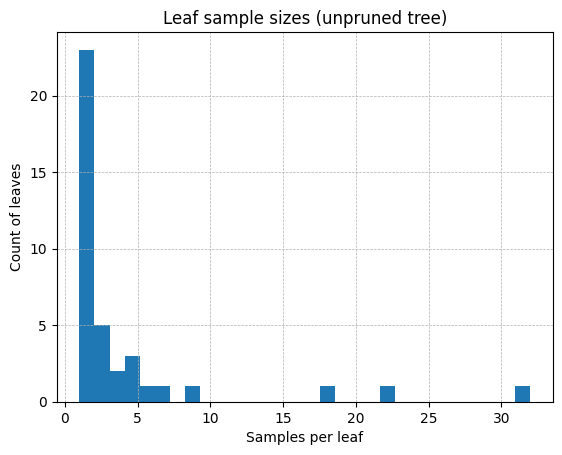

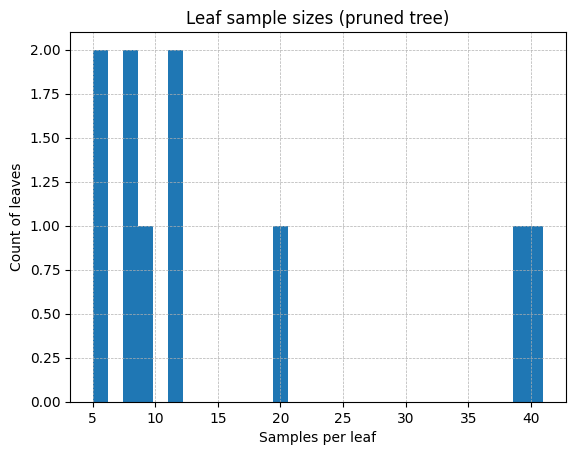

Unpruned: leaves = 39 min/median/max = 1 2 32
Pruned  : leaves = 10 min/median/max = 5 10 41


In [28]:
# Leaf sample size distribution (glass dataset)
# We rely on X_train and y_train created earlier in the notebook.
leaf_id_un = unpruned.apply(X_train)
leaf_id_pr = pruned.apply(X_train)

# Count samples per leaf
counts_un = pd.Series(leaf_id_un).value_counts().values
counts_pr = pd.Series(leaf_id_pr).value_counts().values

plt.figure()
plt.hist(counts_un, bins=30)
plt.xlabel("Samples per leaf")
plt.ylabel("Count of leaves")
plt.title("Leaf sample sizes (unpruned tree)")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.show()

plt.figure()
plt.hist(counts_pr, bins=30)
plt.xlabel("Samples per leaf")
plt.ylabel("Count of leaves")
plt.title("Leaf sample sizes (pruned tree)")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.show()

print("Unpruned: leaves =", len(counts_un), "min/median/max =", int(np.min(counts_un)), int(np.median(counts_un)), int(np.max(counts_un)))
print("Pruned  : leaves =", len(counts_pr), "min/median/max =", int(np.min(counts_pr)), int(np.median(counts_pr)), int(np.max(counts_pr)))
